In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from sklearn.metrics import average_precision_score
import seaborn as sns
from tqdm import tqdm

In [138]:
datasets = [
    "de_novo_v3/5_prime_UTR_variant/9",
    "de_novo_v3/3_prime_UTR_variant/9",
    "de_novo_v3/upstream_gene_variant/9",
    "de_novo_v3/non_coding_transcript_exon_variant/9",
]

models = [
    "gpnmsa",
    "CADD_RawScore",
    "phyloP-100v",
    "phyloP-241m",
    "phastCons-43p",
]

model_renaming = {
    "gpnmsa": "GPN-MSA",
    "CADD_RawScore": "CADD",
}

def load_dataset(dataset):
    V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
    for model in models:
        V = V.with_columns(
            pl.read_parquet(f"../../results/dataset/{dataset}/features/{model}.parquet")["score"].alias(model_renaming.get(model, model))
        )
    return V

#V = load_dataset("de_novo_v3/5_prime_UTR_variant/9")

V = pl.concat((load_dataset(dataset) for dataset in datasets))

models = [model_renaming.get(model, model) for model in models]
V = V.drop_nulls(models)
V

label,chrom,pos,ref,alt,consequence,trait,AF,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-43p
bool,str,i64,str,str,str,str,f64,f32,f32,f64,f64,f64
false,"""21""",18460729,"""C""","""A""","""5_prime_UTR_variant""",null,null,1.75,0.329983,0.212,0.134,0.029
false,"""21""",43954790,"""T""","""A""","""5_prime_UTR_variant""",null,null,0.49,-0.288572,-0.7,-2.217,0.0
false,"""21""",43104732,"""A""","""C""","""5_prime_UTR_variant""",null,null,1.92,0.438464,0.943,-0.514,0.0
false,"""21""",37365964,"""G""","""C""","""5_prime_UTR_variant""",null,null,-0.03,0.208013,-1.112,-0.958,0.0
false,"""21""",44921004,"""C""","""A""","""5_prime_UTR_variant""",null,null,1.73,0.55617,-0.189,-0.542,0.999
…,…,…,…,…,…,…,…,…,…,…,…,…
true,"""3""",169764849,"""G""","""C""","""non_coding_transcript_exon_var…","""Myelodysplastic syndrome""",null,5.84,2.567641,1.119,5.353,0.998
true,"""9""",35657991,"""C""","""G""","""non_coding_transcript_exon_var…","""MIM 250250""",null,8.88,2.490352,7.065,7.13,0.991
true,"""3""",169764756,"""C""","""T""","""non_coding_transcript_exon_var…","""Aplastic anaemia""",null,5.44,3.281707,4.399,8.377,0.999


In [140]:
# TODO: should be careful about setting nan = 0 for conservation models
V.group_by("label").agg(pl.mean(models))

label,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-43p
bool,f32,f32,f64,f64,f64
false,1.82091,0.531316,0.076679,0.199255,0.198083
true,4.94453,1.980193,2.107921,3.785418,0.711238


In [141]:
def odds_ratio_score(y_true, y_pred, threshold_q=0.05):
    df = pl.DataFrame({"label": y_true, "score": -y_pred})
    threshold = df.select(pl.col("score").quantile(threshold_q))["score"]
    # TODO: need to decide how to handle ties... they are certainly an issue with phastCons
    #if threshold_q == 0.05:
    #    print((df["score"] <= threshold).sum())
    group_counts = (
        df.group_by(["label", pl.col("score") <= threshold]).len()
        .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
    )
    #if threshold_q == 0.05:
    #    print(group_counts)
    res = odds_ratio(group_counts, kind="sample")
    ci = res.confidence_interval(confidence_level=0.95)
    return res.statistic, ci.low, ci.high

In [148]:
or_pcts = [
    #1,
    #2,
    5,
    10,
]

or_pct_cols = [f"OR@{or_pct}" for or_pct in or_pcts]

res = []
for model in tqdm(models):
    y_true = V["label"]
    y_pred = V[model]
    res.append((
        model,
        average_precision_score(y_true, y_pred),
        *[odds_ratio_score(y_true, y_pred, or_pct / 100) for or_pct in or_pcts]
    ))
res = pd.DataFrame(res, columns=["model", "AUPRC"] + or_pct_cols)
res

100%|██████████| 5/5 [00:00<00:00, 163.09it/s]


,model,AUPRC,OR@5,OR@10
0,GPN-MSA,0.423518,"(15.295341733486064, 11.312951822770266, 20.67...","(12.858149058149058, 10.132187697563744, 16.31..."
1,CADD,0.548368,"(27.024281577188685, 19.66703556659574, 37.133...","(18.520252771159225, 14.535807053856376, 23.59..."
2,phyloP-100v,0.425278,"(19.45129003558719, 14.315141147228553, 26.430...","(13.91453488372093, 10.956981267017266, 17.670..."
3,phyloP-241m,0.485021,"(19.45129003558719, 14.315141147228553, 26.430...","(20.948328267477205, 16.408663609880847, 26.74..."
4,phastCons-43p,0.317878,"(7.57672829085519, 5.7742675763698195, 9.94183...","(8.165322580645162, 6.444292518823366, 10.3459..."


In [149]:
# Reshape the data from wide to long format for plotting using pandas.melt
res_long = res.melt(
    id_vars="model",
    value_vars=or_pct_cols,
    var_name="%",
    value_name="OR_CI",
)

# Extract OR and CI values into separate columns
# The .str accessor provides an efficient way to split tuples in a Series
res_long['OR'] = res_long['OR_CI'].str[0]
res_long['ci_low'] = res_long['OR_CI'].str[1]
res_long['ci_high'] = res_long['OR_CI'].str[2]
res_long

,model,%,OR_CI,OR,ci_low,ci_high
0,GPN-MSA,OR@5,"(15.295341733486064, 11.312951822770266, 20.67...",15.295342,11.312952,20.679614
1,CADD,OR@5,"(27.024281577188685, 19.66703556659574, 37.133...",27.024282,19.667036,37.133801
2,phyloP-100v,OR@5,"(19.45129003558719, 14.315141147228553, 26.430...",19.451290,14.315141,26.430245
3,phyloP-241m,OR@5,"(19.45129003558719, 14.315141147228553, 26.430...",19.451290,14.315141,26.430245
4,phastCons-43p,OR@5,"(7.57672829085519, 5.7742675763698195, 9.94183...",7.576728,5.774268,9.941834
5,GPN-MSA,OR@10,"(12.858149058149058, 10.132187697563744, 16.31...",12.858149,10.132188,16.317502
6,CADD,OR@10,"(18.520252771159225, 14.535807053856376, 23.59...",18.520253,14.535807,23.596885
7,phyloP-100v,OR@10,"(13.91453488372093, 10.956981267017266, 17.670...",13.914535,10.956981,17.670404
8,phyloP-241m,OR@10,"(20.948328267477205, 16.408663609880847, 26.74...",20.948328,16.408664,26.743949
9,phastCons-43p,OR@10,"(8.165322580645162, 6.444292518823366, 10.3459...",8.165323,6.444293,10.345976


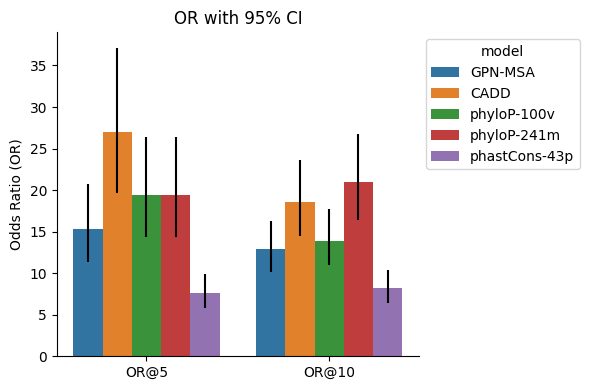

In [150]:
# 1. Create the bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=res_long, x="%", y="OR", hue="model")

# 2. Add custom error bars robustly
for bar in ax.patches:
    # --- THIS IS THE FIX ---
    # Ignore invisible "ghost" patches that seaborn sometimes creates
    if bar.get_height() == 0 and bar.get_width() == 0:
        continue

    # Get the bar's color to identify its hue
    bar_color = bar.get_facecolor()

    # Get the x-tick label for the bar
    x_tick_index = int(round(bar.get_x() + bar.get_width() / 2))
    x_tick_label = ax.get_xticklabels()[x_tick_index].get_text()

    # Get the handles for the legend
    legend_handles, _ = ax.get_legend_handles_labels()

    hue_label = ""
    for handle in legend_handles:
        # Use the .patches[0] version for robustness across matplotlib versions
        if handle.get_facecolor() == bar_color:
            hue_label = handle.get_label()
            break

    # Find the corresponding data row in the DataFrame
    data_row = res_long[(res_long['model'] == hue_label) & (res_long['%'] == x_tick_label)]

    if data_row.empty:
        continue

    # Extract data from the correctly identified row
    ci_low = data_row['ci_low'].iloc[0]
    ci_high = data_row['ci_high'].iloc[0]

    # Use the bar's actual height for y-position and calculation
    bar_height = bar.get_height()

    # Calculate error bar magnitudes
    lower_error = bar_height - ci_low
    upper_error = ci_high - bar_height

    # Ensure errors are positive
    if lower_error < 0: lower_error = 0
    if upper_error < 0: upper_error = 0

    # Get the x-coordinate for the error bar
    x_coord = bar.get_x() + bar.get_width() / 2

    # Plot the correctly aligned error bar
    ax.errorbar(x=x_coord, y=bar_height, yerr=[[lower_error], [upper_error]],
                fmt='none',
                c='black')

# --- Final Touches ---
# Use ax.set_ylim() for setting y-axis limits
ax.set_ylim(bottom=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("OR with 95% CI")
ax.set_ylabel("Odds Ratio (OR)")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()
plt.show()

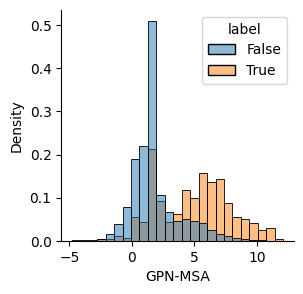

In [161]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="GPN-MSA",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

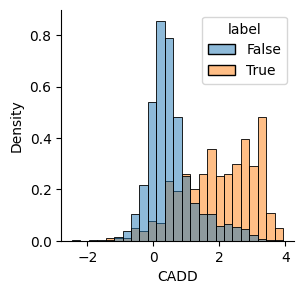

In [162]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="CADD",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

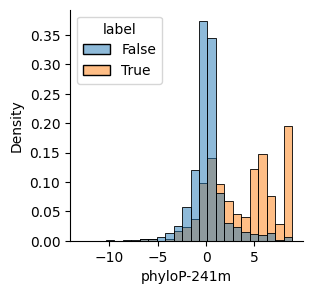

In [163]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="phyloP-241m",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

In [166]:
V.filter(pl.col("label"))["chrom"].value_counts().sort("count")

chrom,count
str,u32
"""18""",1
"""14""",1
"""21""",2
"""6""",2
"""15""",2
…,…
"""13""",31
"""X""",51
"""3""",52
